In [122]:
# import the necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [123]:
# Load dataset
df = pd.read_csv(r"C:\Users\pawan\OneDrive\Documents\Layoff-predictor_app\data\layoffs_raw.csv")

In [124]:
df.head()

,Company,Location HQ,# Laid Off,Date,%,Industry,Source,Stage,$ Raised (mm),Country,Date Added
0,Business Insider,New York City,NaN,5/29/2025,20%,Media,https://www.adweek.com/media/business-insider-...,Acquired,$56,United States,6/2/2025
1,eBay,"Tel Aviv,Non-U.S.",200.0,5/28/2025,NaN,Retail,https://www.calcalistech.com/ctechnews/article...,Post-IPO,$1200,Israel,6/2/2025
2,Cars24,"Gurugram,Non-U.S.",120.0,5/27/2025,NaN,Transportation,https://inc42.com/buzz/cars24-to-fire-120-more...,Series G,$1300,India,5/28/2025
3,nCino,Wilmington,NaN,5/27/2025,7%,Finance,https://www.housingwire.com/articles/ncino-wor...,Post-IPO,$1100,United States,5/29/2025
4,Otipy,"New Delhi,Non-U.S.",300.0,5/23/2025,100%,Food,https://economictimes.indiatimes.com/tech/star...,Series B,$44,India,5/27/2025


In [125]:
df.tail()

,Company,Location HQ,# Laid Off,Date,%,Industry,Source,Stage,$ Raised (mm),Country,Date Added
4073,Service,Los Angeles,NaN,3/16/2020,100%,Travel,https://techcrunch.com/2020/03/16/travel-savin...,Seed,$5,United States,8/31/2020
4074,HopSkipDrive,Los Angeles,8.0,3/13/2020,10%,Transportation,https://layoffs.fyi/2020/04/02/hopskipdrive-la...,Unknown,$45,United States,4/3/2020
4075,Panda Squad,SF Bay Area,6.0,3/13/2020,75%,Consumer,https://twitter.com/danielsinger/status/123854...,Seed,$1,United States,4/17/2020
4076,Tamara Mellon,Los Angeles,20.0,3/12/2020,40%,Retail,https://layoffs.fyi/list/tamara-mellon/,Series C,$90,United States,3/31/2020
4077,EasyPost,Salt Lake City,75.0,3/11/2020,NaN,Logistics,https://www.bizjournals.com/louisville/news/20...,Series A,$12,United States,3/31/2020


basic cleanup and creating the target

In [126]:
print(df.columns)

Index(['Company', 'Location HQ', '# Laid Off', 'Date', '%', 'Industry',
       'Source', 'Stage', '$ Raised (mm)', 'Country', 'Date Added'],
      dtype='object')


In [127]:
# Step 2: Convert date and create target column

df['Date'] = pd.to_datetime(df['Date'])

In [128]:
# Target column: 1 if laid off > 0 else 0
df['will_layoff'] = df['# Laid Off'].apply(lambda x: 1 if pd.notna(x) and x > 0 else 0)

df[['Company', '# Laid Off', 'will_layoff']].head()

,Company,# Laid Off,will_layoff
0,Business Insider,NaN,0
1,eBay,200.0,1
2,Cars24,120.0,1
3,nCino,NaN,0
4,Otipy,300.0,1


In [129]:
# Step 3: Drop unnecessary columns

df = df.drop(columns=['Source', 'Date Added', 'Location HQ'])

In [130]:
# Clean '$ Raised (mm)'
df['$ Raised (mm)'] = df['$ Raised (mm)'].astype(str)
df['$ Raised (mm)'] = df['$ Raised (mm)'].str.replace('[\$,]', '', regex=True)
df['$ Raised (mm)'] = pd.to_numeric(df['$ Raised (mm)'], errors='coerce').fillna(0)

In [131]:
# Step 5: Feature engineering

# Extract year from Date
df['year'] = df['Date'].dt.year

In [132]:
# Select features and target
features = ['Industry', 'Country', '$ Raised (mm)', 'Stage', 'year']
target = 'will_layoff'

In [133]:
df_model = df[features + [target]].copy()
df_model.head()

,Industry,Country,$ Raised (mm),Stage,year,will_layoff
0,Media,United States,56.0,Acquired,2025,0
1,Retail,Israel,1200.0,Post-IPO,2025,1
2,Transportation,India,1300.0,Series G,2025,1
3,Finance,United States,1100.0,Post-IPO,2025,0
4,Food,India,44.0,Series B,2025,1


In [134]:
# Step 6: Encode categorical variables

encoders = {}
for col in ['Industry', 'Country', 'Stage']:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    encoders[col] = le

In [140]:
industry_map_rev = {i: label for i, label in enumerate(encoders['Industry'].classes_)}
country_map_rev = {i: label for i, label in enumerate(encoders['Country'].classes_)}
stage_map_rev = {i: label for i, label in enumerate(encoders['Stage'].classes_)}

print("Industry:", industry_map_rev)
print("Country:", country_map_rev)
print("Stage:", stage_map_rev)

Industry: {0: 'AI', 1: 'Aerospace', 2: 'Construction', 3: 'Consumer', 4: 'Crypto', 5: 'Data', 6: 'Education', 7: 'Energy', 8: 'Finance', 9: 'Fitness', 10: 'Food', 11: 'HR', 12: 'Hardware', 13: 'Healthcare', 14: 'Infrastructure', 15: 'Legal', 16: 'Logistics', 17: 'Manufacturing', 18: 'Marketing', 19: 'Media', 20: 'Other', 21: 'Product', 22: 'Real Estate', 23: 'Recruiting', 24: 'Retail', 25: 'Sales', 26: 'Security', 27: 'Support', 28: 'Transportation', 29: 'Travel', 30: nan}
Country: {0: 'Argentina', 1: 'Australia', 2: 'Austria', 3: 'Bahrain', 4: 'Belgium', 5: 'Brazil', 6: 'Bulgaria', 7: 'Canada', 8: 'Cayman Islands', 9: 'Chile', 10: 'China', 11: 'Colombia', 12: 'Cyprus', 13: 'Czech Republic', 14: 'Denmark', 15: 'Egypt', 16: 'Estonia', 17: 'Finland', 18: 'France', 19: 'Germany', 20: 'Ghana', 21: 'Greece', 22: 'Hong Kong', 23: 'Hungary', 24: 'India', 25: 'Indonesia', 26: 'Ireland', 27: 'Israel', 28: 'Italy', 29: 'Japan', 30: 'Kenya', 31: 'Lithuania', 32: 'Luxembourg', 33: 'Malaysia', 34: 

Saving the cleaned dataset 

In [137]:
df_model.to_csv(r"C:\Users\pawan\OneDrive\Documents\Layoff-predictor_app\data\layoffs_cleaned.csv", index=False)

In [92]:
# Step 7: Train-test split

X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model Selection and Evaluation

In [109]:
 # Step 8: Train Random Forest Classifier and evaluate

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [91]:
print(X.dtypes)

Industry           int32
Country            int32
$ Raised (mm)    float64
Stage              int32
year               int32
dtype: object


In [93]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [94]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [95]:
# Split original data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [97]:
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_resampled.value_counts())

Before SMOTE: will_layoff
1    2126
0    1136
Name: count, dtype: int64
After SMOTE: will_layoff
1    2126
0    2126
Name: count, dtype: int64


In [98]:
# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [110]:
model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred))
print(confusion_matrix(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.49      0.37      0.42       282
           1       0.70      0.80      0.75       534

    accuracy                           0.65       816
   macro avg       0.60      0.58      0.58       816
weighted avg       0.63      0.65      0.63       816

[[104 178]
 [109 425]]


In [100]:
# Model-2

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [101]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [111]:
lr_pred = lr.predict(X_test)
print(classification_report(y_test, lr_pred))
print(confusion_matrix(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       282
           1       0.65      1.00      0.79       534

    accuracy                           0.65       816
   macro avg       0.33      0.50      0.40       816
weighted avg       0.43      0.65      0.52       816

[[  0 282]
 [  0 534]]


c:\Users\pawan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pawan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pawan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [103]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [104]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

c:\Users\pawan\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:10:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [112]:
xgb_pred = xgb.predict(X_test)
print(classification_report(y_test, xgb_pred))
print(confusion_matrix(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.47      0.40      0.43       282
           1       0.71      0.76      0.73       534

    accuracy                           0.64       816
   macro avg       0.59      0.58      0.58       816
weighted avg       0.63      0.64      0.63       816

[[113 169]
 [126 408]]


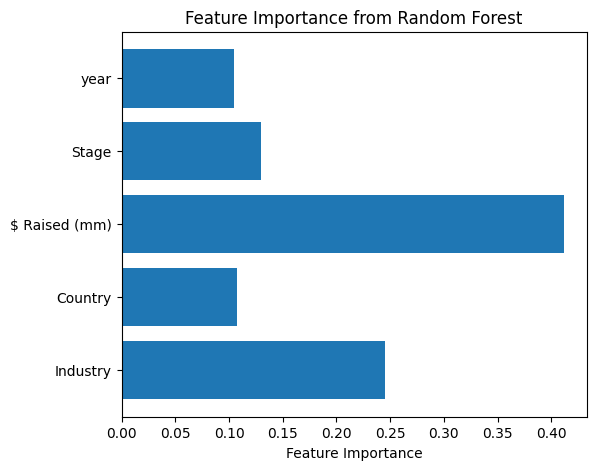

In [117]:
importances = model.feature_importances_
feature_names = X_train.columns  # use your original feature names

plt.figure(figsize=(6, 5))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importance from Random Forest")
plt.show()

Save the Model

In [119]:
import joblib

In [121]:
model_path = r"C:\Users\pawan\OneDrive\Documents\Layoff-predictor_app\models"
model_filename = "random_forest_model.pkl"
full_path = os.path.join(model_path, model_filename)

# Create the directory if it doesn't exist
if not os.path.exists(model_path):
    os.makedirs(model_path)

# Save the model
joblib.dump(model, full_path)
print(f"Model saved at: {full_path}")

Model saved at: C:\Users\pawan\OneDrive\Documents\Layoff-predictor_app\models\random_forest_model.pkl


In [138]:
# If df_model is your final DataFrame after preprocessing and feature selection
print("Model Input Features:")
print(df_model.columns.tolist())

# Optional: check shape and data types too
print("\nShape:", df_model.shape)
print("\nData Types:\n", df_model.dtypes)


Model Input Features:
['Industry', 'Country', '$ Raised (mm)', 'Stage', 'year', 'will_layoff']

Shape: (4078, 6)

Data Types:
 Industry           int32
Country            int32
$ Raised (mm)    float64
Stage              int32
year               int32
will_layoff        int64
dtype: object
